2018015414

In [1]:
# import tools for analyzing timeseries
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [8]:
# Load the dataset
file_path = 'AirPassengers.csv'
data = pd.read_csv(file_path, header=None)

# Display the first few rows of the dataset
data.head()

,0,1
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [9]:
# Rename columns and convert 'timestamp' to datetime
data.columns = ['timestamp', 'Passengers']
data['timestamp'] = pd.to_datetime(data['timestamp'], format='%Y-%m')
data.set_index('timestamp', inplace=True)
data.head()

,Passengers
timestamp,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


first we need to devide data to two part. In-sample and out sample. </br>
As Project Pdf said we use the first 10 years for estimation and rest of 2 years for one-step ahead forecasting


In [10]:
# genrally in time series we use in-sample and out-sample as a term but I prefer train, test for code
train = data[:'1958-12-01']
test = data['1959-01-01':]

In [11]:
train_diff1 = train.diff().dropna()
train_diff2 = train_diff1.diff().dropna()

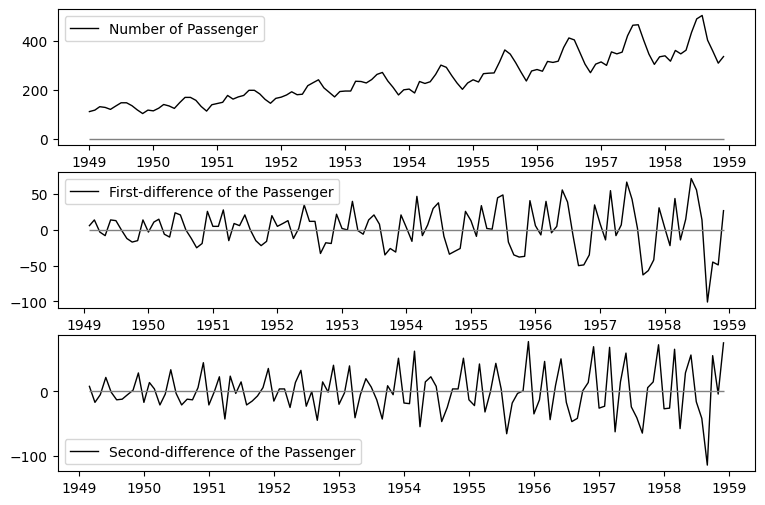

In [177]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 2*3))
axes[0].plot(train,color='black',linewidth=1,label='Number of Passenger')
axes[0].hlines(xmin=train.index[0],xmax=train.index[-1],y=0,color='gray',linewidth=1)
axes[0].legend()
#.diff() pandas 차분지원
axes[1].plot(train_diff1,color='black',linewidth=1,label='First-difference of the Passenger')
axes[1].hlines(xmin=train_diff1.index[0],xmax=train_diff1.index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()
axes[2].plot(train_diff2,color='black',linewidth=1,label='Second-difference of the Passenger')
axes[2].hlines(xmin=train_diff2.index[0],xmax=train_diff2.index[-1],y=0,color='gray',linewidth=1)
axes[2].legend()
plt.show()

The number of passenger looks like there is some trend(increasing) and doesn't have structual break </br> 
Thus it is reasonable to visually conclude that the number of passenger is not stationary(because of trend) </br>
Also it seems like there is volatility increasing depends on time(at diff data, second diff data too)</br>
So it is reasonable to have some transform, we choose log transform </br>

In [109]:
train_log = np.log1p(train)
train_logdiff1 = train_log.diff().dropna()
train_logdiff2 = train_logdiff1.diff().dropna()

In [110]:
train_logdiff1.head()

timestamp
1949-02-01    0.051736
1949-03-01    0.111226
1949-04-01   -0.022815
1949-05-01   -0.063513
1949-06-01    0.108634
Name: Passengers, dtype: float64

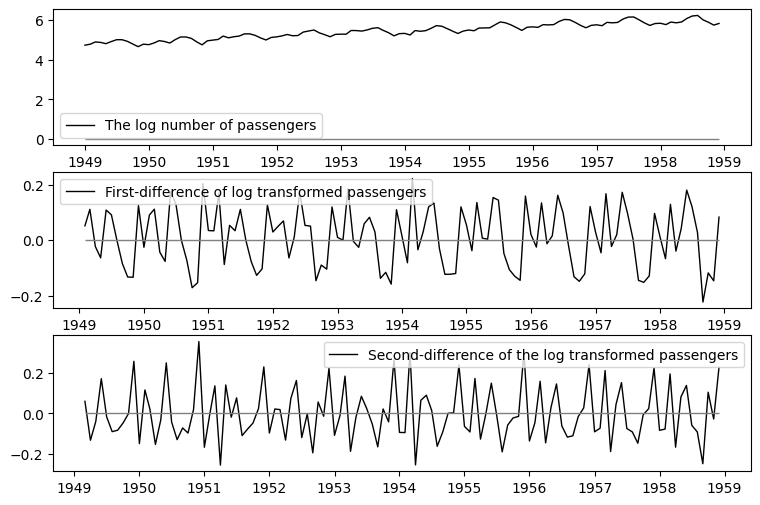

In [178]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 2*3))
axes[0].plot(train_log,color='black',linewidth=1,label='The log number of passengers')
axes[0].hlines(xmin=train_log.index[0],xmax=train_log.index[-1],y=0,color='gray',linewidth=1)
axes[0].legend()
#.diff() pandas 차분지원
axes[1].plot(train_logdiff1,color='black',linewidth=1,label='First-difference of log transformed passengers')
axes[1].hlines(xmin=train_logdiff1.index[0],xmax=train_logdiff1.index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()
axes[2].plot(train_logdiff2,color='black',linewidth=1,label='Second-difference of the log transformed passengers')
axes[2].hlines(xmin=train_logdiff2.index[0],xmax=train_logdiff2.index[-1],y=0,color='gray',linewidth=1)
axes[2].legend()
plt.show()

It is reasonable to say first differece and second differnce seems more stable than data before transform(visually conclude) </br> 
 we will use ADF and KPSS test for stationary check first

# Check Stationary

In [112]:
def adf_test(dataframe):
  result = adfuller(dataframe)
  print(f'Statistics: {result[0]}')
  print(f'p-value: {result[1]}')
  print(f'Critical values: {result[4]}')

adf_test(train)
print('---'*40)
adf_test(train_diff1)
print('---'*40)
adf_test(train_diff2)
print('---'*40)
adf_test(train_logdiff1)
print('---'*40)
adf_test(train_logdiff2)
print('---'*40)
#adf test null: serise is non stationary
#p-value가 0.05보다 작므면 기각(95%유의수준)
#critical value보다 작으면 기각(해당 유의수준내에서)

Statistics: -0.7734607708969381
p-value: 0.8267937485032447
Critical values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}
------------------------------------------------------------------------------------------------------------------------
Statistics: -2.1641431278047762
p-value: 0.21951577637150677
Critical values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}
------------------------------------------------------------------------------------------------------------------------
Statistics: -13.947363642065772
p-value: 4.7704196840302815e-26
Critical values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}
------------------------------------------------------------------------------------------------------------------------
Statistics: -2.3438063037286336
p-value: 0.15822839568723085
Critical values: {'1%': -3.4936021509366793, '5%': -2.8892174239808703, '10%': -2.58153320754717}

The ADF test results show that the p-value is very high (0.82), indicating that the series is not stationary. We need to difference the data to achieve stationarity. </br>
If you seed the p-value you can find origin and first differences(also log transfromed data) do not reject null </br>
We can find second derivative((also log transfromed data) reject the null, wich mean it is stationary

In [113]:
def kpss_test(dataframe):
  result = kpss(dataframe)
  print(f'Statistics: {result[0]}')
  print(f'bounded p-value: {result[1]}')
  print(f'Critical values: {result[3]}')

kpss_test(train)
print('---'*40)
kpss_test(train_diff1)
print('---'*40)
kpss_test(train_diff2)
print('---'*40)
kpss_test(train_logdiff1)
print('---'*40)
kpss_test(train_logdiff2)

Statistics: 1.7058124992217791
bounded p-value: 0.01
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.019023125650029386
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.08275298336937394
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.029471641004343525
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics

C:\Users\zin\AppData\Local\Temp\ipykernel_3520\3624022375.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  result = kpss(dataframe)
C:\Users\zin\AppData\Local\Temp\ipykernel_3520\3624022375.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(dataframe)
C:\Users\zin\AppData\Local\Temp\ipykernel_3520\3624022375.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(dataframe)
C:\Users\zin\AppData\Local\Temp\ipykernel_3520\3624022375.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value return

The KPSS test suggests that the first differenced series(also log transformed) is stationary, but the ADF test is not as conclusive. which means trend stationary </br>
The KPSS test&ADF test suggests that the second differenced series((also log transformed)) is stationary. </br>
we need to check the ACF and PACF plots for further insights.

# Candidate Model
ACF & PACF

1. d=1

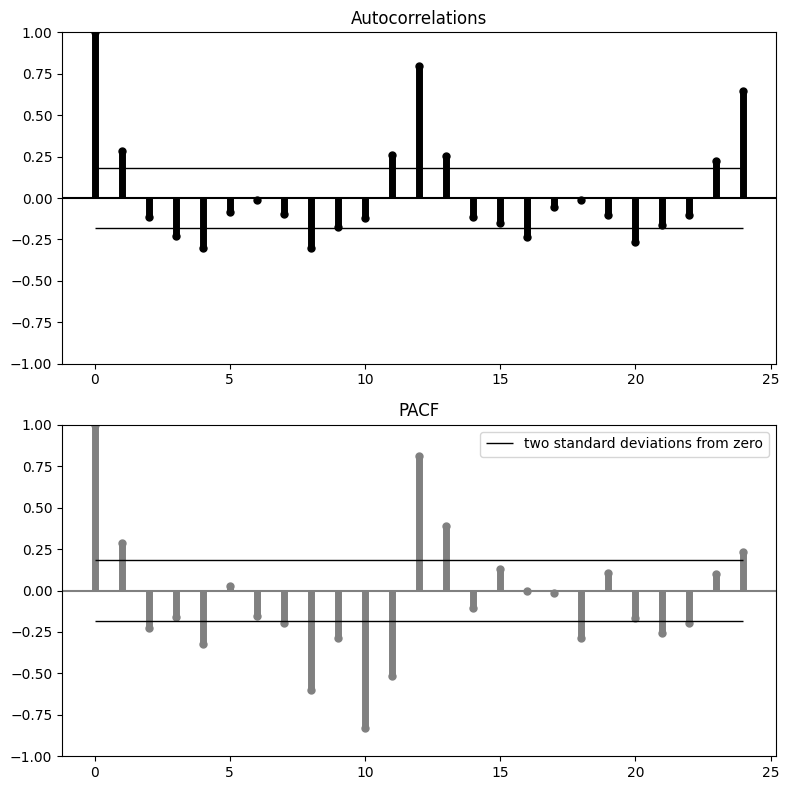

In [114]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(train_diff1, lags=24, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
axes[0].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_diff1)),label='two standard deviations from zero',color='black',linewidth=1)
axes[0].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_diff1)),color='black',linewidth=1)
plot_pacf(train_diff1, lags=24, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[1].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_diff1)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_diff1)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

1. The ACF and PACF show us a cyclical(seasonal?) pattern(12), which seems like they has seasonality 
2. The ACF does not cut to zero so that we can rule out a pure MA(q) process.
3. The ACF plot shows significant spikes at lag 1, 12, and 24.

There is a gradual decay in the autocorrelations.
These patterns suggest the presence of seasonal components, given the regular spikes at higher lags.

4. PACF analysis

The PACF plot shows significant spikes at lag 1, 8, 10, 12. 

The initial spike at lag 1 indicates that an AR(1) component may be necessary.

The PACF does not cut off quickly, which could indicate a mixture of autoregressive components and/or seasonal autoregressive components.


So for the given information suggested model are </br>

1. since the series has been diffence, d=1 
2. siginificant spike at lag 1 in PACF suggests AR(1). p=1
3. significant splike at lag 1 in ACF suggests MA(1). so q=1 or 0, [1,4]

there is some seasonal components at ACF and PACF, s=10, P=1. D=1. Q=1 or 2 or for s=4?

2. d=2

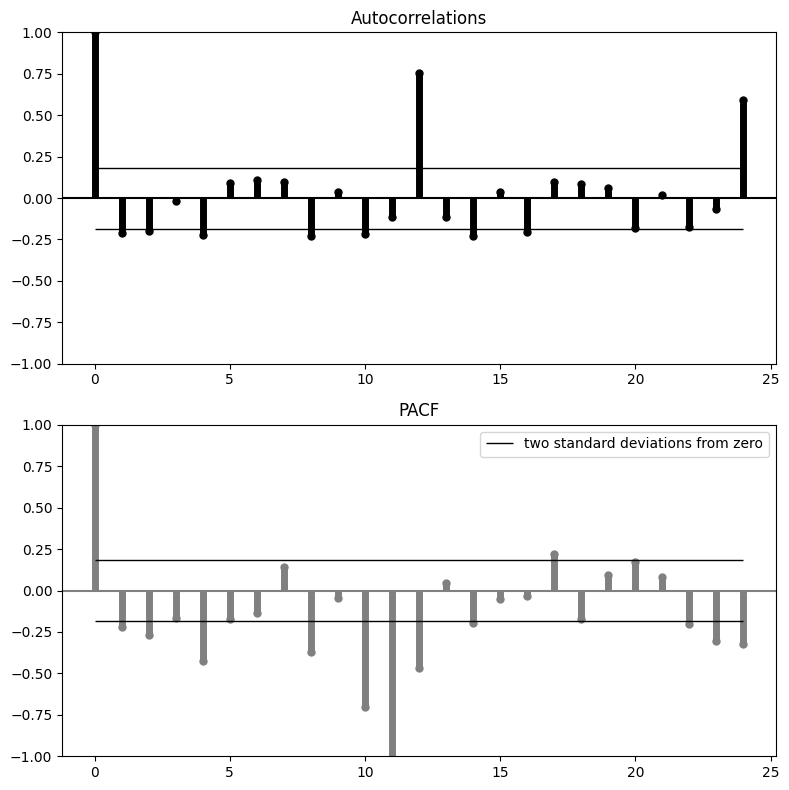

In [115]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(train_diff2, lags=24, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(train_diff2, lags=24, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[0].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_diff2)),label='two standard deviations from zero',color='black',linewidth=1)
axes[0].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_diff2)),color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_diff2)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_diff2)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

1. The ACF and PACF show us a cyclical pattern(12), which seems like they has seasonality 
2. The ACF does not cut to zero so that we can rule out a pure MA(q) process.
3. ACF
The ACF plot shows significant spikes at lag 1 and 12, with the spikes decaying slowly over time. This suggests the presence of a seasonal component around lag 12.</br>
The spike at lag 24 is also notable and might suggest another seasonal cycle, but the primary focus should remain on the first noticeable seasonality at lag 12.
4. PACF
The PACF plot shows a significant spike at lag 1 and 2, indicating a possible AR(1) or AR(2) component. </br>
The significant spikes at lags 10,11,12 seasonal autoregressive components at these lags.

So for the given information suggested model are </br>

1. since the series has been diffence, d=2 
2. siginificant spike at lag 1 in PACF suggests AR(1), AR(2). p=1, 2
3. significant splike at lag 1,2 in ACF suggests MA(1), MA(2). so q= 0, 1, 2

some seasonal component s=12

3. d=1, log transformed

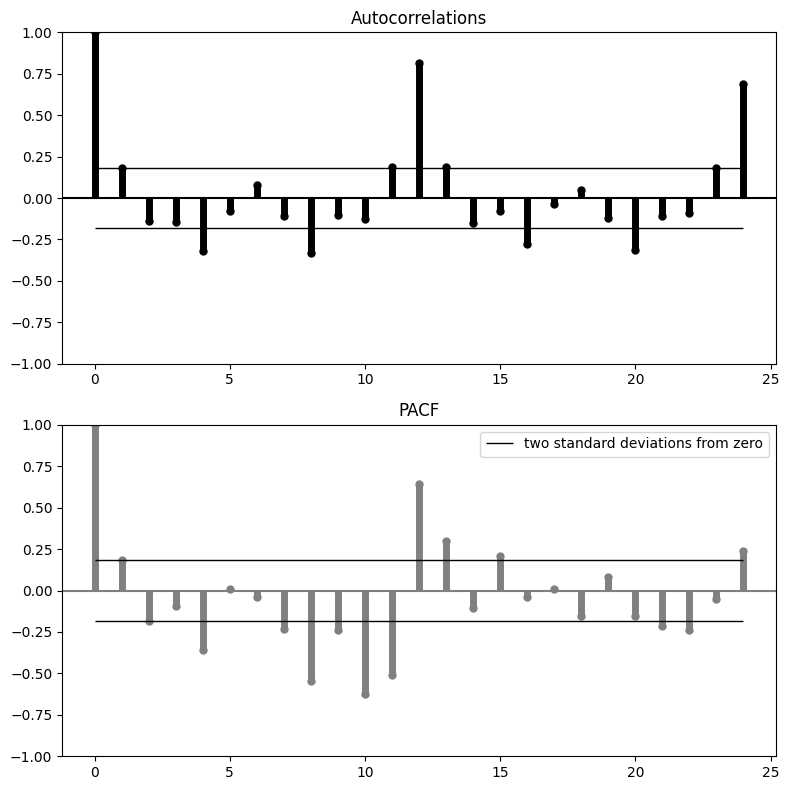

In [116]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(train_logdiff1, lags=24, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(train_logdiff1, lags=24, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[0].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_logdiff1)),label='two standard deviations from zero',color='black',linewidth=1)
axes[0].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_logdiff1)),color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_logdiff1)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_logdiff1)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

1. The ACF and PACF show us a cyclical pattern(12), which seems like they has seasonality 
2. The ACF does not cut to zero so that we can rule out a pure MA(q) process.
3. ACF: Significant spikes at lags 1, 12, and 24. </br>
4. PACF: Significant spikes at lag 1 and 4 also at 10~12

So for the given information suggested model are </br>

1. since the series has been diffence, d=1
2. siginificant spike at lag 1 in PACF suggests AR(1), AR([1,4])
3. significant splike at lag 1  ACF suggests MA(1), MA([1,4])

4. d=2 log transformed

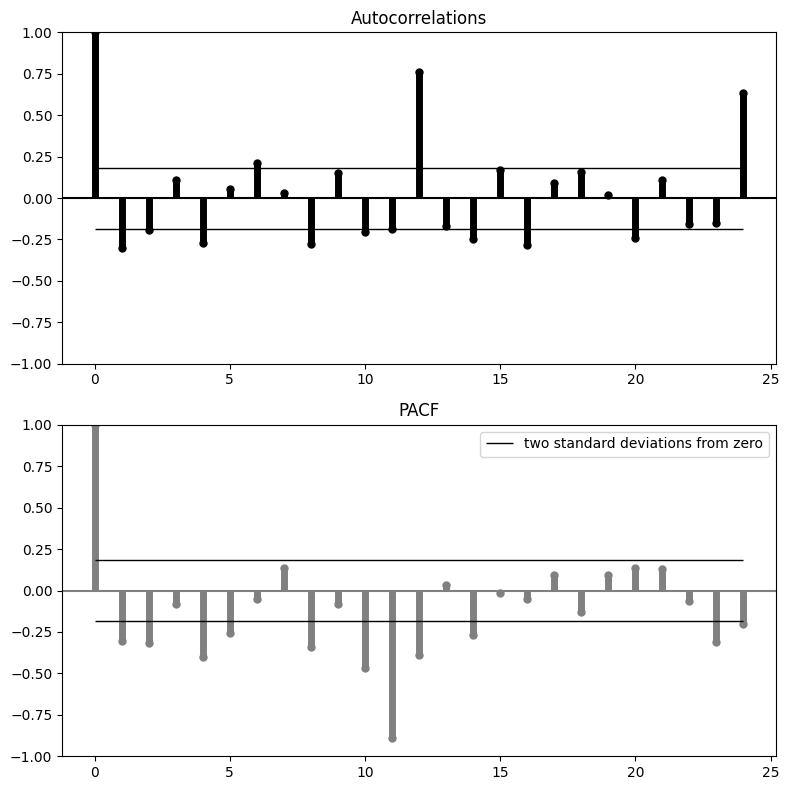

In [117]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(train_logdiff2, lags=24, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(train_logdiff2, lags=24, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[0].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_logdiff2)),label='two standard deviations from zero',color='black',linewidth=1)
axes[0].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_logdiff2)),color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_logdiff2)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_logdiff2)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

1. The ACF and PACF show us a cyclical pattern(12), which seems like they has seasonality 
2. The ACF does not cut to zero so that we can rule out a pure MA(q) process.
3. ACF: Siginificant spike at 1,4 /  12
4. PACF: Siginificant spike at 1,2,4 and 10,11,12

So for the given information suggested model are </br>

1. since the series has been diffence, d=2
2. siginificant spike at lag 1,2 in PACF suggests AR(1), AR(2)
3. significant splike at lag 1  ACF suggests MA(1), MA([1,4])

In [118]:
def get_max_value(element):
  if isinstance(element, int) or isinstance(element, float):
    return element
  else:
    return max(element)

first for origin data(not log transformed)

In [45]:
lag_list = [(1,1,0), (1,1,1), (1,1,[1,4]), (1,2,0), (1,2,1), (1,2,2), (2,2,0), (2,2,1), (2,2,2)]

summary_table = dict()

idx=0
num_of_obs = len(train[4:])

for lag in lag_list:
    # SSE i.e SSR, AIC, SBC, Ljung–Box Q-statistics of the residual autocorrelations for lag:={4, 8, 12}.
    temp_perf_dict = {key: key for key in ['SSE','AIC','SBC','Q(4)','Q(8)','Q(12)']}

    # Get the maximum value(s) from each element in the set
    max_values = [get_max_value(elem) for elem in lag]
    max_element = max(max_values)
    # We use spread[4-max_element:] to estimate each equation over the 1961Q4-2012Q4.
    res = ARIMA(endog = train[4-max_element:], order=lag).fit() # Use Durbin–Levinson algorithm. You can also use other estimation method.
    temp_perf_dict['SSE'] = round(res.sse,2)
    
    # Note that since we assume the model errors are IID according to a normal distribution, the BIC and AIC formula is bit different from a general form.
    temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),2)
    temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),2)
    
    # Ljung-box Q-statistics for lag 4,8,12
    q_statistics = res.test_serial_correlation(method='ljungbox',lags=12)[0]

    temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val': round(q_statistics[1][3],2)}
    temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val': round(q_statistics[1][7],2)}
    temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2), 'p_val': round(q_statistics[1][11],2)}

    for param_name, param in zip(res.params.index, res.params):
        temp_perf_dict[param_name] = {'coef':round(param,2), 't_stats':round(res.tvalues[param_name],2)}
    
    hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']]) # make res.specification['order'] hashable.
    summary_table[hashable_order] = temp_perf_dict

c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.v

In [46]:
table_2_4 = pd.DataFrame()
for key, value in summary_table.items():
    temp_series = pd.Series(value, name=key)
    table_2_4 = pd.concat([table_2_4,temp_series],axis=1)

The null hypothesis (H0) of the Ljung-Box test is that the residuals are independently distributed (i.e., no significant autocorrelation at lags being tested).

which means that if residual is independent distributted it should not reject the null, p-val > 0.05

In [47]:
table_2_4

,"(1, 1, 0)","(1, 1, 1)","(1, 1, (1, 4))","(1, 2, 0)","(1, 2, 1)","(1, 2, 2)","(2, 2, 0)","(2, 2, 1)","(2, 2, 2)"
SSE,106481.71,100992.23,87938.32,154909.81,113372.3,107805.44,145923.47,108950.32,107142.52
AIC,1346.78,1342.64,1328.59,1390.27,1356.06,1352.22,1385.34,1353.44,1353.5
SBC,1352.29,1350.91,1339.6,1395.78,1364.32,1363.23,1393.6,1364.46,1367.27
Q(4),"{'q_stats': 14.71, 'p_val': 0.01}","{'q_stats': 14.45, 'p_val': 0.01}","{'q_stats': 5.25, 'p_val': 0.26}","{'q_stats': 16.71, 'p_val': 0.0}","{'q_stats': 14.55, 'p_val': 0.01}","{'q_stats': 14.42, 'p_val': 0.01}","{'q_stats': 17.23, 'p_val': 0.0}","{'q_stats': 12.09, 'p_val': 0.02}","{'q_stats': 12.35, 'p_val': 0.01}"
Q(8),"{'q_stats': 23.86, 'p_val': 0.0}","{'q_stats': 23.17, 'p_val': 0.0}","{'q_stats': 9.13, 'p_val': 0.33}","{'q_stats': 27.38, 'p_val': 0.0}","{'q_stats': 23.63, 'p_val': 0.0}","{'q_stats': 23.13, 'p_val': 0.0}","{'q_stats': 31.33, 'p_val': 0.0}","{'q_stats': 24.02, 'p_val': 0.0}","{'q_stats': 20.06, 'p_val': 0.01}"
Q(12),"{'q_stats': 108.58, 'p_val': 0.0}","{'q_stats': 94.66, 'p_val': 0.0}","{'q_stats': 84.56, 'p_val': 0.0}","{'q_stats': 115.54, 'p_val': 0.0}","{'q_stats': 108.12, 'p_val': 0.0}","{'q_stats': 94.26, 'p_val': 0.0}","{'q_stats': 110.84, 'p_val': 0.0}","{'q_stats': 99.52, 'p_val': 0.0}","{'q_stats': 92.74, 'p_val': 0.0}"
ar.L1,"{'coef': 0.29, 't_stats': 3.0}","{'coef': -0.51, 't_stats': -3.41}","{'coef': -0.11, 't_stats': -0.6}","{'coef': -0.22, 't_stats': -1.91}","{'coef': 0.29, 't_stats': 2.77}","{'coef': -0.51, 't_stats': -3.15}","{'coef': -0.27, 't_stats': -2.48}","{'coef': 0.36, 't_stats': 3.49}","{'coef': -0.52, 't_stats': -3.5}"
sigma2,"{'coef': 774.42, 't_stats': 9.11}","{'coef': 726.53, 't_stats': 8.27}","{'coef': 632.44, 't_stats': 8.37}","{'coef': 1144.13, 't_stats': 8.45}","{'coef': 772.9, 't_stats': 0.09}","{'coef': 724.35, 't_stats': 0.09}","{'coef': 1066.4, 't_stats': 8.99}","{'coef': 734.55, 't_stats': 0.03}","{'coef': 718.65, 't_stats': 0.05}"
ma.L1,NaN,"{'coef': 0.88, 't_stats': 8.81}","{'coef': 0.48, 't_stats': 3.78}",NaN,"{'coef': -1.0, 't_stats': -0.09}","{'coef': -0.13, 't_stats': -0.01}",NaN,"{'coef': -1.0, 't_stats': -0.03}","{'coef': -0.07, 't_stats': -0.0}"
ma.L4,NaN,NaN,"{'coef': -0.38, 't_stats': -3.7}",NaN,NaN,NaN,NaN,NaN,NaN


Note that Ljung–Box Q-statistics can serve as a check to see if the residuals from an estimated ARMA(p, q) model behave as a white-noise process.

(The t-statistics at 5% significance level is 1.93.)

So we choose (1,1,0), (1,1,1)

c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


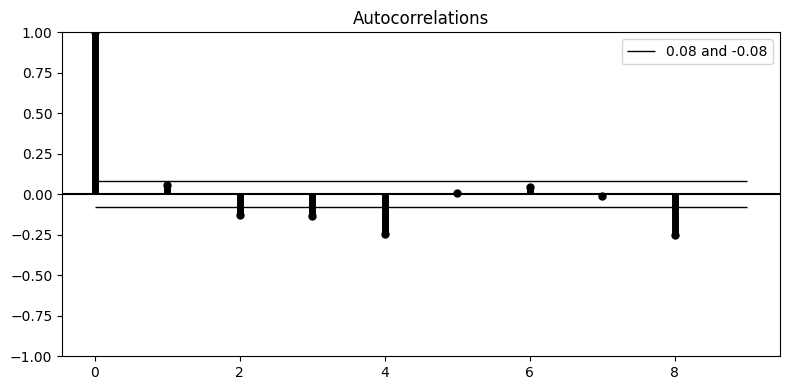

In [48]:


f, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
res = ARIMA(endog = train, order=(1,1,0)).fit()
# the ACF of the last model's residuals.
plot_acf(res.resid, lags=8, ax=axes, title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
axes.hlines(xmin=0,xmax=9,y=0.08,label='0.08 and -0.08',color='black',linewidth=1)
axes.hlines(xmin=0,xmax=9,y=-0.08,color='black',linewidth=1)
axes.legend()
plt.tight_layout()
plt.show()

Check for log transform data

In [128]:
lag_list = [(1,1,0), (1,1,1), (1,1,[1,4]), ([1,4],1,0), ([1,4], 1, 1), ([1,4],1,[1,4]), (1,2,0), (1,2,1), (1,2,[1,4]), (2,2,0), (2,2,1), (2,2,[1,4])]

# ARIMA(p,d,q)

summary_table = dict()

idx=0
num_of_obs = len(train_log[4:])

for lag in lag_list:
    # SSE i.e SSR, AIC, SBC, Ljung–Box Q-statistics of the residual autocorrelations for lag:={4, 8, 12}.
    temp_perf_dict = {key: key for key in ['SSE','AIC','SBC','Q(4)','Q(8)','Q(12)']}

    # Get the maximum value(s) from each element in the set
    max_values = [get_max_value(elem) for elem in lag]
    max_element = max(max_values)
    # We use spread[4-max_element:] to estimate each equation over the 1961Q4-2012Q4.
    res = ARIMA(endog = train_log[4-max_element:], order=lag).fit() # Use Durbin–Levinson algorithm. You can also use other estimation method.
    temp_perf_dict['SSE'] = round(res.sse,2)
    
    # Note that since we assume the model errors are IID according to a normal distribution, the BIC and AIC formula is bit different from a general form.
    temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),2)
    temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),2)
    
    # Ljung-box Q-statistics for lag 4,8,12
    q_statistics = res.test_serial_correlation(method='ljungbox',lags=12)[0]

    temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val': round(q_statistics[1][3],2)}
    temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val': round(q_statistics[1][7],2)}
    temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2), 'p_val': round(q_statistics[1][11],2)}

    for param_name, param in zip(res.params.index, res.params):
        temp_perf_dict[param_name] = {'coef':round(param,2), 't_stats':round(res.tvalues[param_name],2)}
    
    hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']]) # make res.specification['order'] hashable.
    summary_table[hashable_order] = temp_perf_dict

c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.v

In [130]:
table_3_4 = pd.DataFrame()
for key, value in summary_table.items():
    temp_series = pd.Series(value, name='log'+str(key))
    table_3_4 = pd.concat([table_3_4,temp_series],axis=1)

In [131]:
table_3_4

,"log(1, 1, 0)","log(1, 1, 1)","log(1, 1, (1, 4))","log((1, 4), 1, 0)","log((1, 4), 1, 1)","log((1, 4), 1, (1, 4))","log(1, 2, 0)","log(1, 2, 1)","log(1, 2, (1, 4))","log(2, 2, 0)","log(2, 2, 1)","log(2, 2, (1, 4))"
SSE,24.95,24.89,23.44,23.5,23.48,23.46,31.92,31.3,28.81,31.75,31.27,29.0
AIC,377.16,378.87,373.91,372.22,374.11,376.04,405.74,405.47,397.86,407.1,407.34,400.61
SBC,382.67,387.13,384.93,380.48,385.12,389.81,411.24,413.73,408.87,415.36,418.35,414.38
Q(4),"{'q_stats': 15.47, 'p_val': 0.0}","{'q_stats': 11.74, 'p_val': 0.02}","{'q_stats': 5.23, 'p_val': 0.26}","{'q_stats': 11.72, 'p_val': 0.02}","{'q_stats': 6.26, 'p_val': 0.18}","{'q_stats': 21.66, 'p_val': 0.0}","{'q_stats': 20.06, 'p_val': 0.0}","{'q_stats': 15.5, 'p_val': 0.0}","{'q_stats': 17.66, 'p_val': 0.0}","{'q_stats': 19.32, 'p_val': 0.0}","{'q_stats': 14.24, 'p_val': 0.01}","{'q_stats': 13.62, 'p_val': 0.01}"
Q(8),"{'q_stats': 29.47, 'p_val': 0.0}","{'q_stats': 23.3, 'p_val': 0.0}","{'q_stats': 10.98, 'p_val': 0.2}","{'q_stats': 18.06, 'p_val': 0.02}","{'q_stats': 14.42, 'p_val': 0.07}","{'q_stats': 34.45, 'p_val': 0.0}","{'q_stats': 38.86, 'p_val': 0.0}","{'q_stats': 29.36, 'p_val': 0.0}","{'q_stats': 36.89, 'p_val': 0.0}","{'q_stats': 36.23, 'p_val': 0.0}","{'q_stats': 28.31, 'p_val': 0.0}","{'q_stats': 22.82, 'p_val': 0.0}"
Q(12),"{'q_stats': 116.11, 'p_val': 0.0}","{'q_stats': 98.91, 'p_val': 0.0}","{'q_stats': 91.26, 'p_val': 0.0}","{'q_stats': 104.61, 'p_val': 0.0}","{'q_stats': 91.24, 'p_val': 0.0}","{'q_stats': 112.0, 'p_val': 0.0}","{'q_stats': 131.11, 'p_val': 0.0}","{'q_stats': 115.84, 'p_val': 0.0}","{'q_stats': 122.54, 'p_val': 0.0}","{'q_stats': 119.89, 'p_val': 0.0}","{'q_stats': 108.87, 'p_val': 0.0}","{'q_stats': 93.53, 'p_val': 0.0}"
ar.L1,"{'coef': 0.19, 't_stats': 1.82}","{'coef': -0.58, 't_stats': -2.95}","{'coef': -0.1, 't_stats': -0.43}","{'coef': 0.15, 't_stats': 1.6}","{'coef': -0.16, 't_stats': -0.63}","{'coef': 0.17, 't_stats': 1.56}","{'coef': -0.31, 't_stats': -2.22}","{'coef': 0.19, 't_stats': 1.69}","{'coef': 0.26, 't_stats': 2.58}","{'coef': -0.4, 't_stats': -3.15}","{'coef': 0.22, 't_stats': 1.97}","{'coef': -0.02, 't_stats': -0.05}"
sigma2,"{'coef': 0.01, 't_stats': 5.48}","{'coef': 0.01, 't_stats': 5.43}","{'coef': 0.01, 't_stats': 5.99}","{'coef': 0.01, 't_stats': 5.75}","{'coef': 0.01, 't_stats': 5.81}","{'coef': 0.01, 't_stats': 5.48}","{'coef': 0.02, 't_stats': 7.34}","{'coef': 0.01, 't_stats': 0.02}","{'coef': 0.01, 't_stats': 4.38}","{'coef': 0.01, 't_stats': 7.7}","{'coef': 0.01, 't_stats': 0.02}","{'coef': 0.01, 't_stats': 3.41}"
ma.L1,NaN,"{'coef': 0.83, 't_stats': 6.9}","{'coef': 0.32, 't_stats': 1.85}",NaN,"{'coef': 0.42, 't_stats': 1.71}","{'coef': -0.09, 't_stats': -1.02}",NaN,"{'coef': -1.0, 't_stats': -0.02}","{'coef': -1.32, 't_stats': -11.37}",NaN,"{'coef': -1.0, 't_stats': -0.02}","{'coef': -0.56, 't_stats': -0.96}"
ma.L4,NaN,NaN,"{'coef': -0.37, 't_stats': -3.63}",NaN,NaN,"{'coef': 0.99, 't_stats': 9.38}",NaN,NaN,"{'coef': 0.33, 't_stats': 2.84}",NaN,NaN,"{'coef': -0.44, 't_stats': -2.35}"


we choose (1,1,1), (1,1,0)

c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


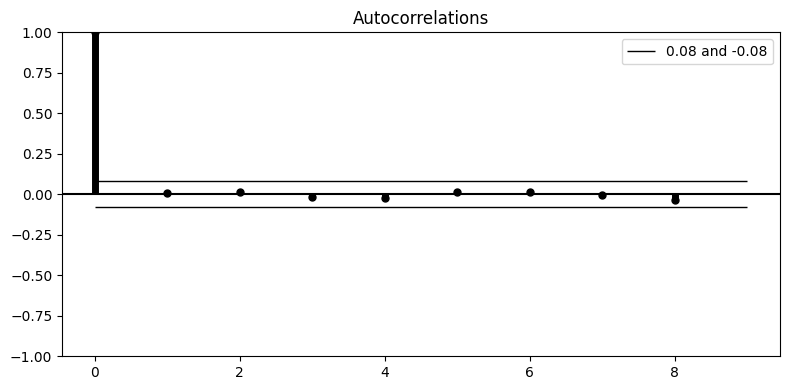

In [121]:
f, axes = plt.subplots(nrows=1, ncols=1, figsize=(8, 4))
# the ACF of the last model's residuals.
res = ARIMA(endog = train_log, order=(1,1,1)).fit()
plot_acf(res.resid, lags=8, ax=axes, title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
axes.hlines(xmin=0,xmax=9,y=0.08,label='0.08 and -0.08',color='black',linewidth=1)
axes.hlines(xmin=0,xmax=9,y=-0.08,color='black',linewidth=1)
axes.legend()
plt.tight_layout()
plt.show()

In [133]:
# generally in time series we use in-sample and out-sample as a term but I prefer train, test for code
train_set = data[:'1958-12-01']
test_set = data['1959-01-01':]

n_train = len(train_set)
n_test = len(test_set)

f1, f1_error = [], []
f2, f2_error = [], []
f3, f3_error = [], []
f4, f4_error = [], []
ground_truth = []

for i in range(n_test):
    crt_time = i + n_train 
    x_train = data[:crt_time] 

    # iterate over the time series data, fitting the model on each expanding window of data
    model_1 = ARIMA(endog=x_train, order=(1,1,0)).fit()  # model 1
    model_2 = ARIMA(endog=x_train, order=(1,1,1)).fit()  # model 2
    model_3 = ARIMA(endog=np.log1p(x_train), order=(1,1,0)).fit()  # model 3
    model_4 = ARIMA(endog=np.log1p(x_train), order=(1,1,1)).fit()  # model 4
    # one-step-ahead forecasts
    forecast_1 = model_1.forecast(steps=1)
    forecast_2 = model_2.forecast(steps=1)
    forecast_3 = np.expm1(model_3.forecast(steps=1))  # Inverse log transformation
    forecast_4 = np.expm1(model_4.forecast(steps=1))  # Inverse log transformation
    # true one-step-ahead value
    y = data['Passengers'].iloc[crt_time]

    ground_truth.append(y)

    f1.append(forecast_1[0])
    f1_error.append(y - forecast_1[0])

    f2.append(forecast_2[0])
    f2_error.append(y - forecast_2[0])

    f3.append(forecast_3[0])
    f3_error.append(y - forecast_3[0])

    f4.append(forecast_4[0])
    f4_error.append(y - forecast_4[0])


c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.v

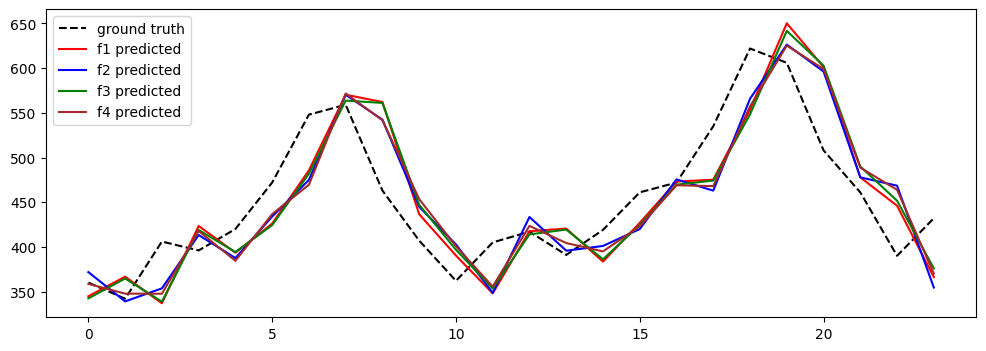

In [134]:
# plot the results
plt.figure(figsize=(12,4))
plt.plot(ground_truth, label='ground truth', color='k', linestyle='--')
plt.plot(f1, label='f1 predicted', color='r')
plt.plot(f2, label='f2 predicted', color='b')
plt.plot(f3, label='f3 predicted', color='g')
plt.plot(f4, label='f4 predicted', color='brown')
plt.legend()
plt.show()

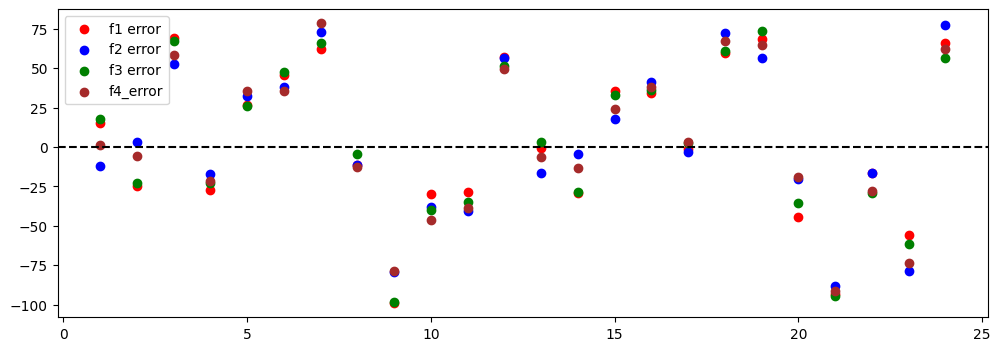

In [135]:
# plot the results
plt.figure(figsize=(12,4))
plt.scatter(np.linspace(1,len(f1_error),len(f1_error)), f1_error, label='f1 error', color='r')
plt.scatter(np.linspace(1,len(f2_error),len(f2_error)), f2_error, label='f2 error', color='b')
plt.scatter(np.linspace(1,len(f3_error),len(f3_error)), f3_error, label='f3 error', color='g')
plt.scatter(np.linspace(1,len(f4_error),len(f4_error)), f4_error, label='f4_error', color='brown')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.show()

In [62]:
def calculate_mape(predictions, targets):
  targets = np.where(targets == 0, 1, targets)

  mape = np.mean(np.abs((targets - predictions) / targets)) * 100
  return mape

In [136]:
mape = calculate_mape(f1, ground_truth)
print("ARIMA 1 모델의 MAPE:", mape)
mape = calculate_mape(f2, ground_truth)
print("ARIMA 2 모델의 MAPE:", mape)
mape = calculate_mape(f3, ground_truth)
print("ARIMA 3 모델의 MAPE:", mape)
mape = calculate_mape(f4, ground_truth)
print("ARIMA 4 모델의 MAPE:", mape)

ARIMA 1 모델의 MAPE: 9.178345877874667
ARIMA 2 모델의 MAPE: 8.676044484174565
ARIMA 3 모델의 MAPE: 9.310470284080651
ARIMA 4 모델의 MAPE: 8.69580000437253


# Extra: Seasonality ARIMA model

Seasonal Auto Regressive Integrated Moving Average
SARIMA model is an extension of the ARIMA model that can handle the seasonal effects of the data.
It has kind of 2 orders (p,d,q) x (P,D,Q,M).
(p,d,q) is the order that is similar to the order of the ARIMA model.
(P,D,Q,M) is known as the Seasonal Order where (P,D,Q) are similar to the (p,d,q) of the ARIMA model.
It's selection criteria is similar as well with an important condition i.e to handle the seasonality by differencing the data with the frequency of seasonal period or periodicity, M and check the PACF & ACF values at the Mth lag value.


In [145]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [66]:
train.head()

,Passengers
timestamp,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


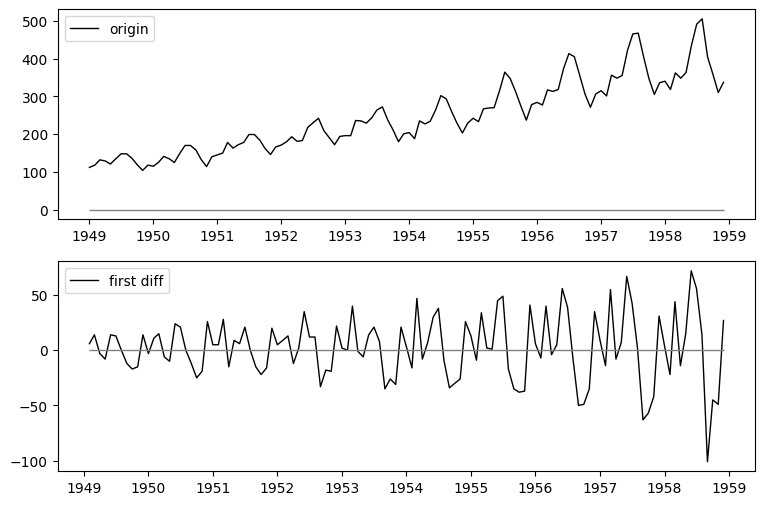

In [154]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 2*3))
axes[0].plot(train,color='black',linewidth=1,label='origin')
axes[0].hlines(xmin=train.index[0],xmax=train.index[-1],y=0,color='gray',linewidth=1)
axes[0].legend()
#.diff() pandas 차분지원
axes[1].plot(train_diff1,color='black',linewidth=1,label='first diff')
axes[1].hlines(xmin=train_diff1.index[0],xmax=train_diff1.index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()
plt.show()

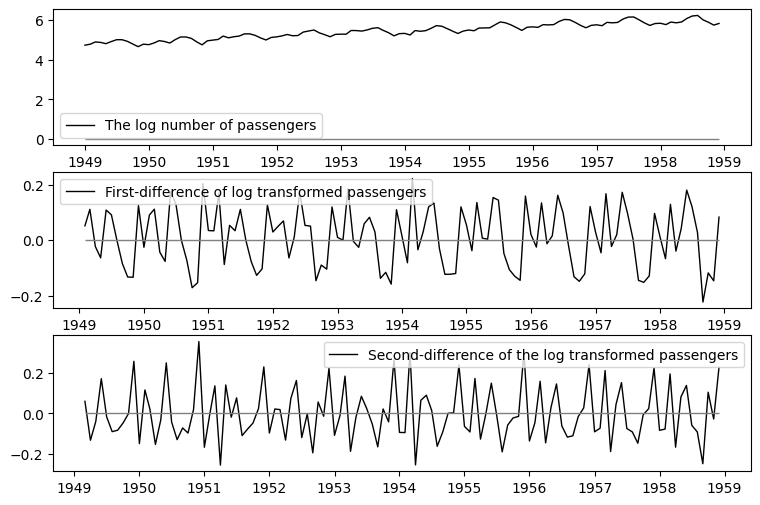

In [155]:
f, axes = plt.subplots(nrows=3, ncols=1, figsize=(9, 2*3))
axes[0].plot(train_log,color='black',linewidth=1,label='The log number of passengers')
axes[0].hlines(xmin=train_log.index[0],xmax=train_log.index[-1],y=0,color='gray',linewidth=1)
axes[0].legend()
#.diff() pandas 차분지원
axes[1].plot(train_logdiff1,color='black',linewidth=1,label='First-difference of log transformed passengers')
axes[1].hlines(xmin=train_logdiff1.index[0],xmax=train_logdiff1.index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()
axes[2].plot(train_logdiff2,color='black',linewidth=1,label='Second-difference of the log transformed passengers')
axes[2].hlines(xmin=train_logdiff2.index[0],xmax=train_logdiff2.index[-1],y=0,color='gray',linewidth=1)
axes[2].legend()
plt.show()

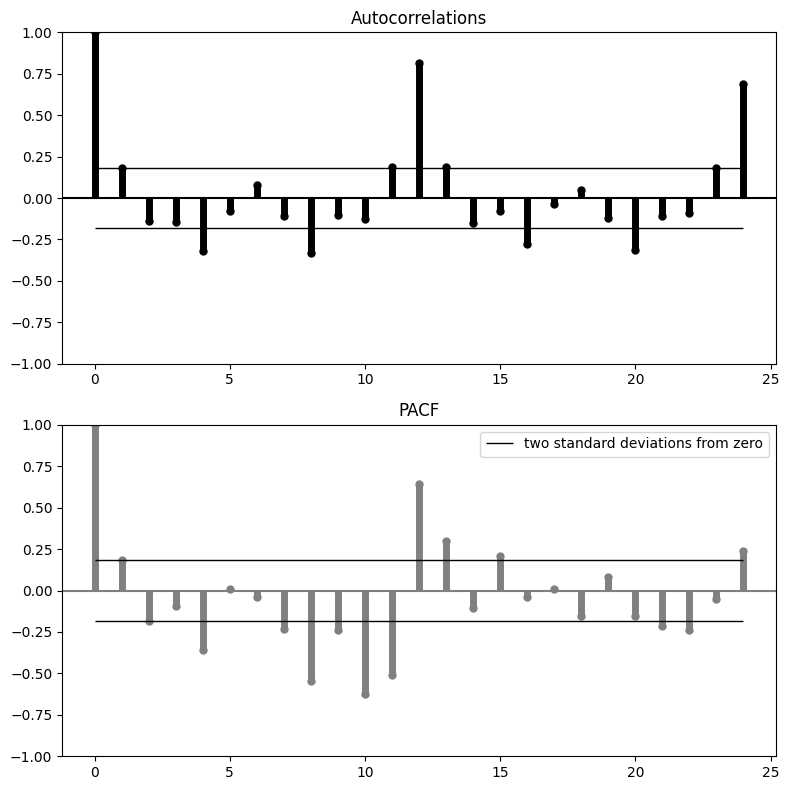

In [156]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(train_logdiff1, lags=24, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(train_logdiff1, lags=24, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[0].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_logdiff1)),label='two standard deviations from zero',color='black',linewidth=1)
axes[0].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_logdiff1)),color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_logdiff1)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_logdiff1)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

In [167]:
train_log_diff1q = np.log1p(train).diff().diff(4).dropna()
train_log_diff1s = np.log1p(train).diff().diff(12).dropna()


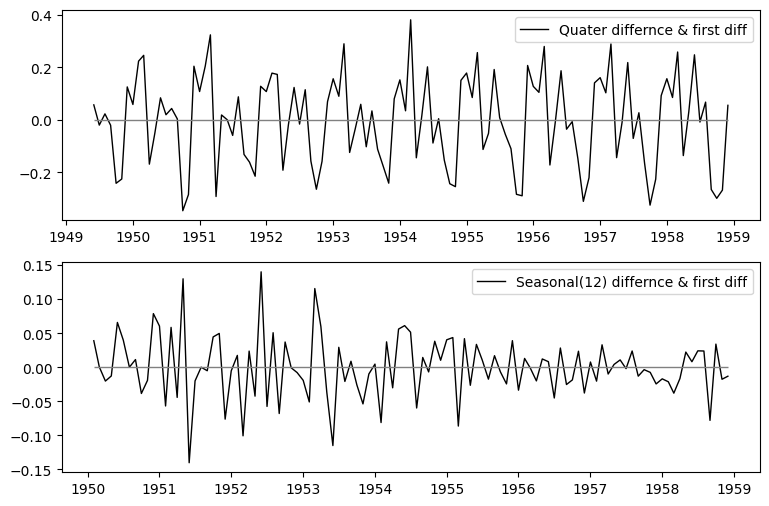

In [168]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(9, 2*3))
axes[0].plot(train_log_diff1q,color='black',linewidth=1,label='Quater differnce & first diff')
axes[0].hlines(xmin=train_log_diff1q.index[0],xmax=train_log_diff1q.index[-1],y=0,color='gray',linewidth=1)
axes[0].legend()
#.diff() pandas 차분지원
axes[1].plot(train_log_diff1s,color='black',linewidth=1,label='Seasonal(12) differnce & first diff')
axes[1].hlines(xmin=train_log_diff1s.index[0],xmax=train_log_diff1s.index[-1],y=0,color='gray',linewidth=1)
axes[1].legend()
plt.show()

In [169]:
adf_test(train_log_diff1q)
print('---'*40)
adf_test(train_log_diff1s)
print('---'*40)

Statistics: -7.471068823960859
p-value: 5.053276878814045e-11
Critical values: {'1%': -3.4948504603223145, '5%': -2.889758398668639, '10%': -2.5818220155325444}
------------------------------------------------------------------------------------------------------------------------
Statistics: -4.0039391597087555
p-value: 0.0013900245361742575
Critical values: {'1%': -3.5011373281819504, '5%': -2.8924800524857854, '10%': -2.5832749307479226}
------------------------------------------------------------------------------------------------------------------------


In [170]:
kpss_test(train_log_diff1q)
print('---'*40)
kpss_test(train_log_diff1s)
print('---'*40)

Statistics: 0.025737087376037707
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------
Statistics: 0.13944322654671631
bounded p-value: 0.1
Critical values: {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739}
------------------------------------------------------------------------------------------------------------------------


C:\Users\zin\AppData\Local\Temp\ipykernel_3520\3624022375.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(dataframe)
C:\Users\zin\AppData\Local\Temp\ipykernel_3520\3624022375.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  result = kpss(dataframe)


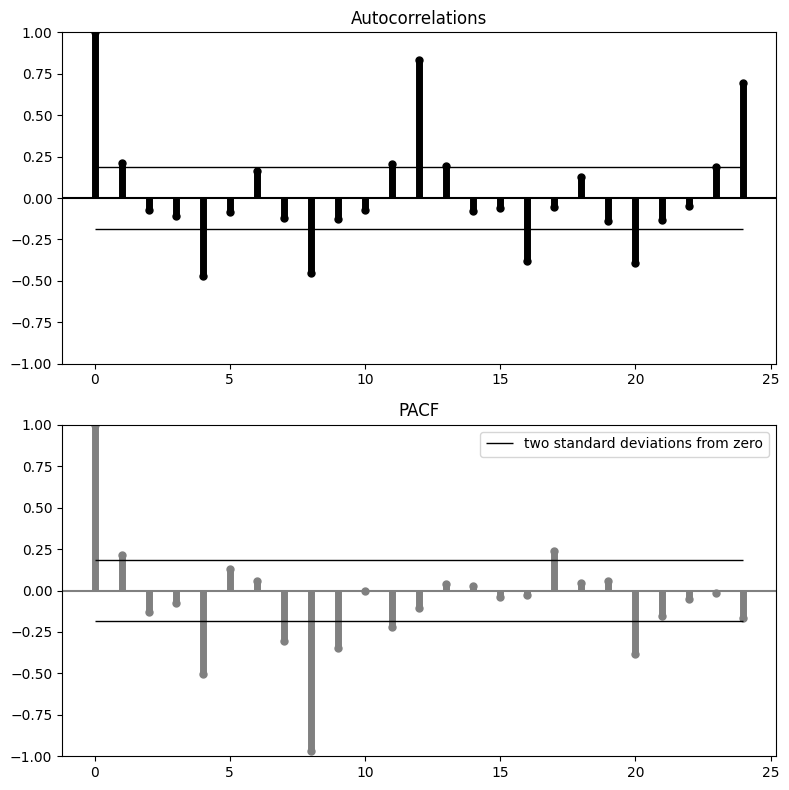

In [171]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(train_log_diff1q, lags=24, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(train_log_diff1q, lags=24, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[0].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_log_diff1q)),label='two standard deviations from zero',color='black',linewidth=1)
axes[0].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_log_diff1q)),color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_log_diff1q)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_log_diff1q)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

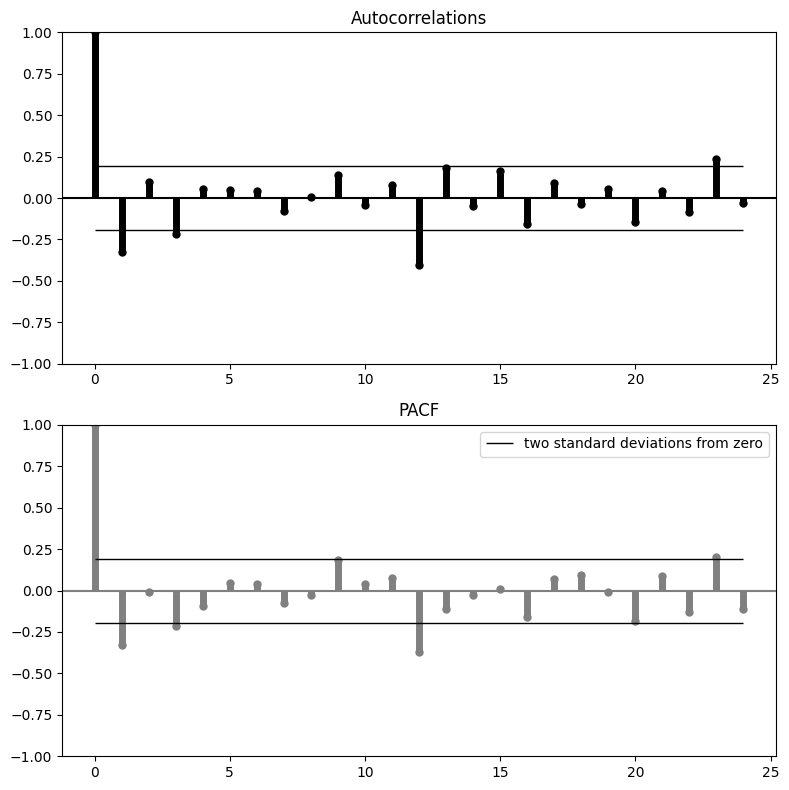

In [166]:
f, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 2*4))
plot_acf(train_log_diff1s, lags=24, ax=axes[0], title='Autocorrelations', color='black',vlines_kwargs={'colors':'black','linewidth':5}, alpha=None)
plot_pacf(train_log_diff1s, lags=24, ax=axes[1], method='ols', title='PACF', color='gray',vlines_kwargs={'colors':'gray','linewidth':5}, alpha=None)
axes[0].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_log_diff1s)),label='two standard deviations from zero',color='black',linewidth=1)
axes[0].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_log_diff1s)),color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=2*np.sqrt(1/len(train_log_diff1s)),label='two standard deviations from zero',color='black',linewidth=1)
axes[1].hlines(xmin=0,xmax=24,y=-2*np.sqrt(1/len(train_log_diff1s)),color='black',linewidth=1)
axes[1].legend()
plt.tight_layout()
plt.show()

In [137]:

summary_table = dict()

idx=0
num_of_obs = len(train_log[12:])


# SSE i.e SSR, AIC, SBC, Ljung–Box Q-statistics of the residual autocorrelations for lag:={4, 8, 12}.
temp_perf_dict = {key: key for key in ['SSE','AIC','SBC','Q(4)','Q(8)','Q(12)']}

max_element = 12

# We use spread[4-max_element:] to estimate each equation over the 1961Q4-2012Q4.
res = sm.tsa.statespace.SARIMAX(train_log[12-max_element:], order=(1, 1, 1), seasonal_order=(1, 1, 1, 12)).fit()
temp_perf_dict['SSE'] = round(res.sse,2)

# Note that since we assume the model errors are IID according to a normal distribution, the BIC and AIC formula is bit different from a general form.
temp_perf_dict['AIC'] = round(num_of_obs*np.log(res.sse) + 2*len(res.params),2)
temp_perf_dict['SBC'] = round(num_of_obs*np.log(res.sse) + len(res.params)*np.log(num_of_obs),2)

# Ljung-box Q-statistics for lag 4,8,12
q_statistics = res.test_serial_correlation(method='ljungbox',lags=12)[0]

temp_perf_dict['Q(4)'] = {'q_stats' : round(q_statistics[0][3],2), 'p_val': round(q_statistics[1][3],2)}
temp_perf_dict['Q(8)'] = {'q_stats' : round(q_statistics[0][7],2), 'p_val': round(q_statistics[1][7],2)}
temp_perf_dict['Q(12)'] = {'q_stats' : round(q_statistics[0][11],2), 'p_val': round(q_statistics[1][11],2)}

for param_name, param in zip(res.params.index, res.params):
    temp_perf_dict[param_name] = {'coef':round(param,2), 't_stats':round(res.tvalues[param_name],2)}

hashable_order = tuple([tuple(order) if isinstance(order,list) == True else order for order in res.specification['order']]) # make res.specification['order'] hashable.
summary_table[hashable_order] = temp_perf_dict

c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [143]:
sarima_table = pd.DataFrame()
for key, value in summary_table.items():
    temp_series = pd.Series(value, name=str(key))
    sarima_table = pd.concat([sarima_table,temp_series],axis=1)

In [144]:
sarima_table

,"(1, 1, 1)"
SSE,28.31
AIC,371.07
SBC,384.48
Q(4),"{'q_stats': 3.33, 'p_val': 0.5}"
Q(8),"{'q_stats': 4.33, 'p_val': 0.83}"
Q(12),"{'q_stats': 5.14, 'p_val': 0.95}"
ar.L1,"{'coef': 0.19, 't_stats': 0.72}"
ma.L1,"{'coef': -0.53, 't_stats': -2.19}"
ar.S.L12,"{'coef': -0.07, 't_stats': -0.29}"
ma.S.L12,"{'coef': -0.49, 't_stats': -1.83}"


In [172]:

# genrally in time series we use in-sample and out-sample as a term but I prefer train, test for code
train_set = data[:'1958-12-01']
test_set = data['1959-01-01':]

n_train = len(train_set)
n_test = len(test_set)

sf1, sf1_error = [], []

ground_truth = []

order = (1, 1, 1)
seasonal_order = (1, 1, 1, 12)

for i in range(n_test):
    crt_time = i + n_train 
    x_train = data[:crt_time] 

    model = sm.tsa.statespace.SARIMAX(np.log1p(x_train), order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    # one-step-ahead forecasts
    forecast = np.expm1(model_fit.forecast(steps=1))

    # true one-step-ahead value
    y = data['Passengers'][crt_time]

    ground_truth.append(y)

    sf1.append(forecast[0])
    sf1_error.append(y-forecast[0])


c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\zin\Developer\TAF\TAF_individual_project\.venv\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\zin\AppData\Local\Temp\ipykernel_3520\1763932231.py:25: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by pos

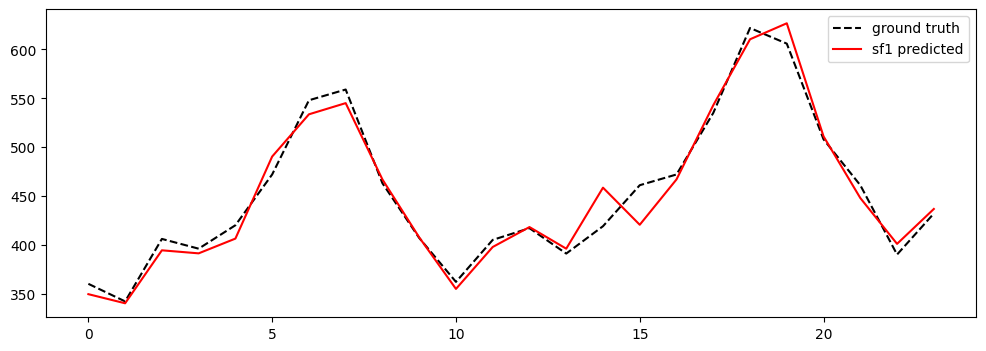

In [173]:
# plot the results
plt.figure(figsize=(12,4))
plt.plot(ground_truth, label='ground truth', color='k', linestyle='--')
plt.plot(sf1, label='sf1 predicted', color='r')
plt.legend()
plt.show()

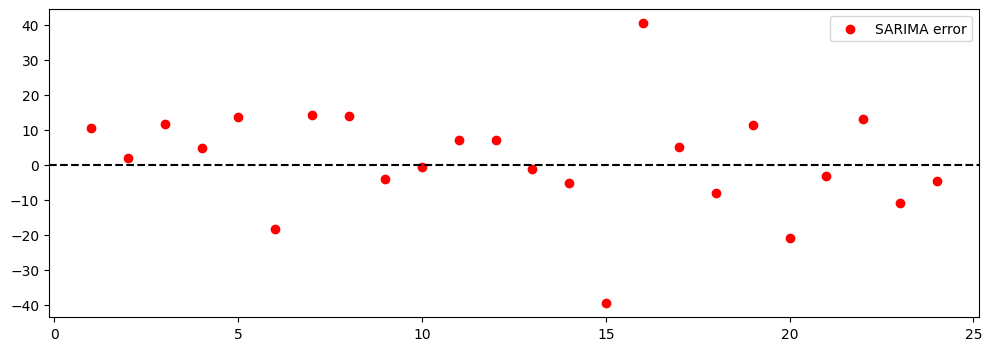

In [174]:
# plot the results
plt.figure(figsize=(12,4))
plt.scatter(np.linspace(1,len(sf1_error),len(sf1_error)), sf1_error, label='SARIMA error', color='r')
plt.axhline(y=0, color='k', linestyle='--')
plt.legend()
plt.show()

In [175]:
mape = calculate_mape(sf1, ground_truth)
print("SARIMA 모델의 MAPE:", mape)

SARIMA 모델의 MAPE: 2.4819805796315273
